In [1]:
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import torchaudio
import torch
from torch import nn
from torchsummary import summary

## Helper functions for plotting

In [22]:
# def plot_waveform(waveform, sr, title="Waveform"):
#     waveform = waveform.numpy()
#
#     num_channels, num_frames = waveform.shape
#     time_axis = torch.arange(0, num_frames) / sr
#
#     figure, axes = plt.subplots(num_channels, 1)
#     axes.plot(time_axis, waveform[0], linewidth=1)
#     axes.grid(True)
#     figure.suptitle(title)
#     plt.show(block=False)
#
#
# def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
#     fig, axs = plt.subplots(1, 1)
#     axs.set_title(title or "Spectrogram (db)")
#     axs.set_ylabel(ylabel)
#     axs.set_xlabel("frame")
#     im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
#     fig.colorbar(im, ax=axs)
#     plt.show(block=False)
#
#
# def plot_fbank(fbank, title=None):
#     fig, axs = plt.subplots(1, 1)
#     axs.set_title(title or "Filter bank")
#     axs.imshow(fbank, aspect="auto")
#     axs.set_ylabel("frequency bin")
#     axs.set_xlabel("mel bin")
#     plt.show(block=False)
hop_length = 512
SAMPLE_RATE = 44100
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=hop_length,
    n_mels=64
)
def _mix_down_if_necessary(signal):
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal
def plot_audio(audio, sr):
    mixed = _mix_down_if_necessary(audio)
    waveform = mixed.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(time_axis, waveform[0], linewidth=1)
    axs[0].grid(True)
    axs[0].set_title("Waveform")
    axs[1].set_title("Spectrogram (db)")
    axs[1].set_ylabel("freq_bin")
    axs[1].set_xlabel("frame")
    im = axs[1].imshow(librosa.power_to_db(mel(mixed)[0]), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs[1])
    fig.set_size_inches(20, 5)
    plt.show(block=False)

# Audio data samples
Collected audio data has been categorised up into ambient and fall samples. Here is an ambient file.

In [28]:
ambient, sr = torchaudio.load('ambient noise/ambient_110_0.wav')
Audio(data=ambient, rate=sr)

The waveform and mel spectogram are shown below

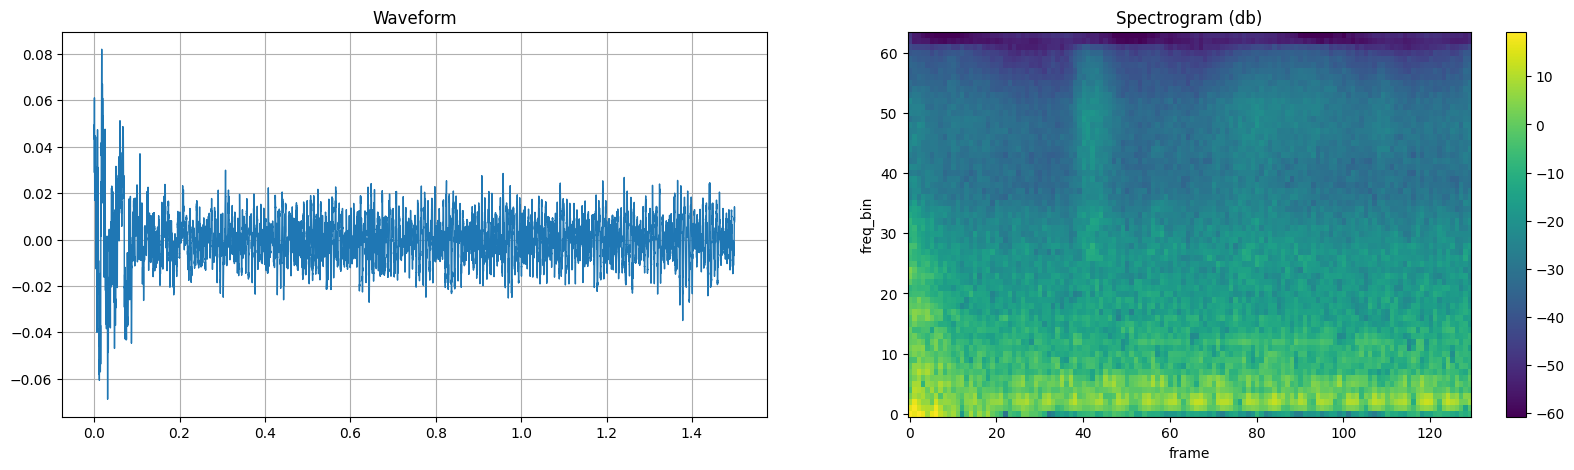

In [29]:
plot_audio(ambient, sr)

When we extract the percussive element we get more definitive edges and a lot of the noise we don't care about is removed

In [30]:
pambient, asr = torchaudio.load('percussive_audio/ambient noise/ambient_110_0.wav')
Audio(data=pambient, rate=asr)

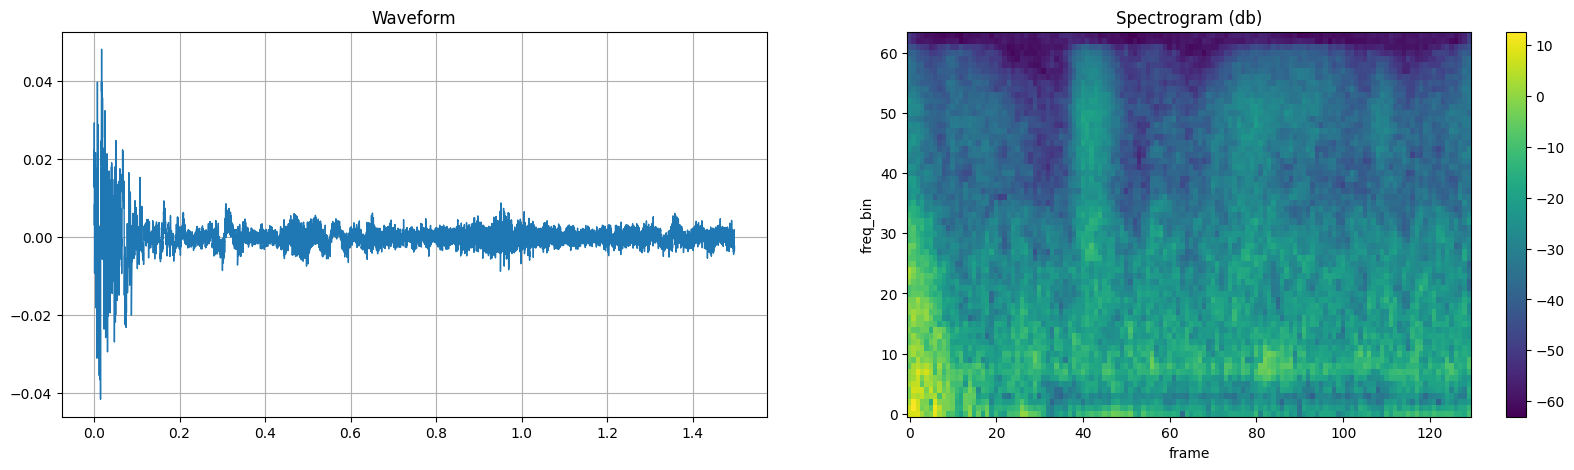

In [31]:
plot_audio(pambient, sr)

We now follow the same process for a fall clip

In [32]:
fall, fsr = torchaudio.load('random_falls/random-fall_2_1.wav')
Audio(data=fall, rate=fsr)

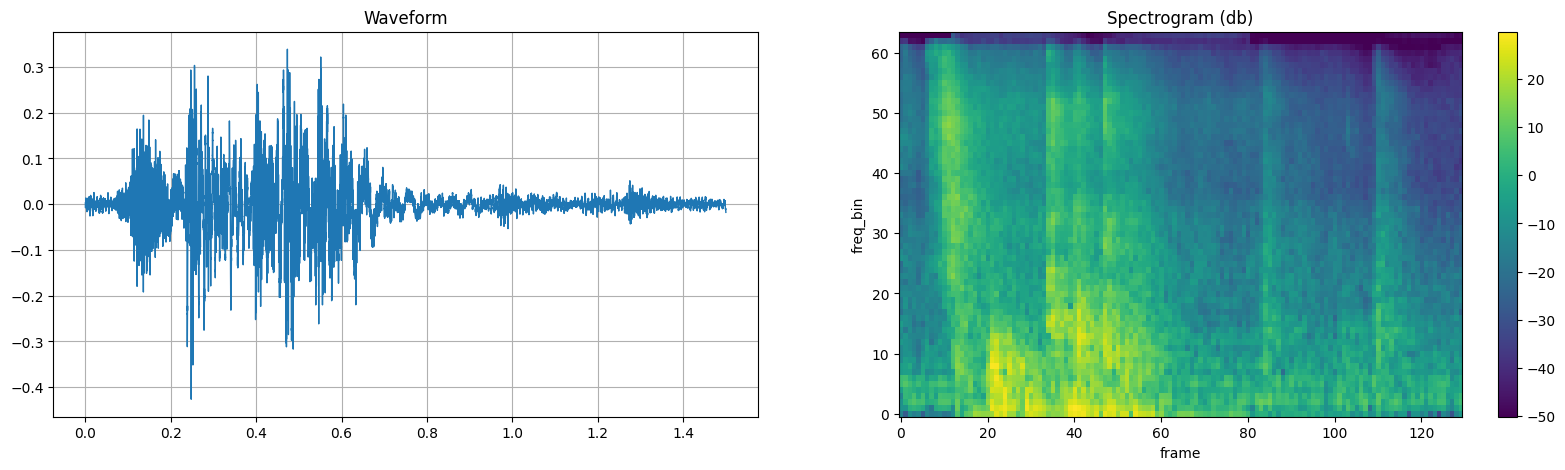

In [33]:
plot_audio(fall, fsr)

In [34]:
pfall, fsr = torchaudio.load('percussive_audio/random_falls/random-fall_2_1.wav')
Audio(data=pfall, rate=fsr)

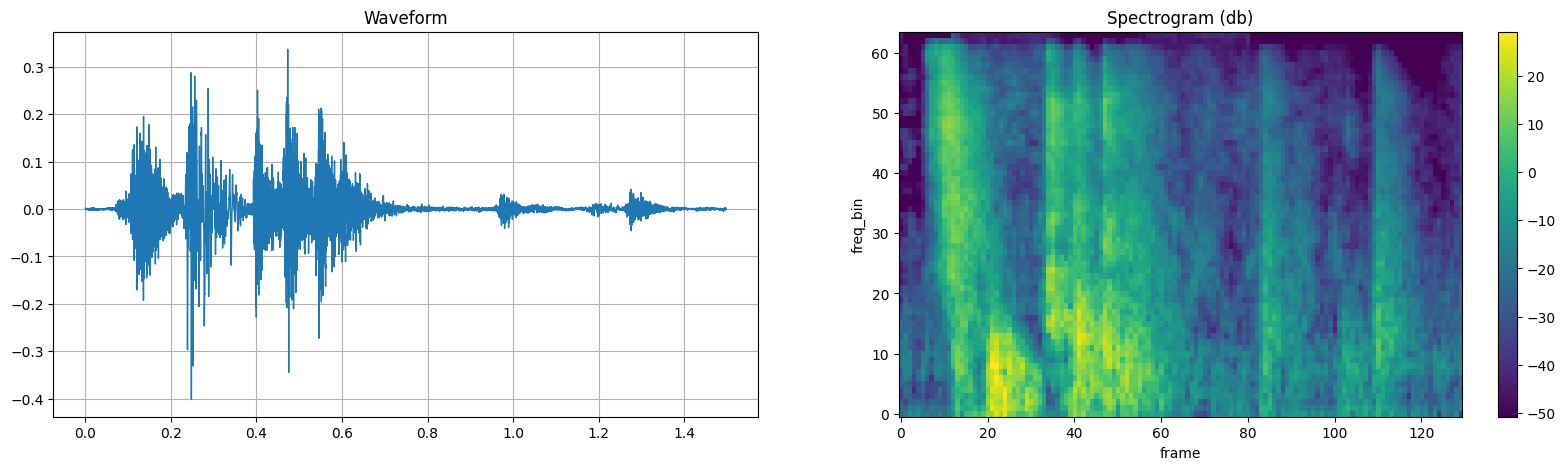

In [36]:
plot_audio(pfall, fsr)

## Convolutional Neural Network
Below is the structure of the convolutional neural network used for our model

In [37]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3200*2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions


# if __name__ == "__main__":
#     if torch.cuda.is_available():
#         device = "cuda"
#     else:
#         device = "cpu"
#     print(f"Using device {device}")
#     cnn = CNNNetwork()
#     summary(cnn.to(device), (1, 64, 65*2))

In [38]:
device = torch.device("cpu")
# cnn = CNNNetwork()
cnn = torch.load('model-fold-2.pth',map_location=device)
cnn.eval()

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=6400, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

# Classification of previous audio samples
We used the percussive audio samples for training so for more accurate results we use them to classify fall vs non fall sounds

In [43]:
def classify_audio(audio):
    fall_spec = _mix_down_if_necessary(signal=audio)
    fall_spec = mel(fall_spec)
    fall_spec = fall_spec[None,:]
    pred = None
    with torch.no_grad():
        pred = cnn(fall_spec)
    return torch.max(pred, 1)

From the above function we get the index for the result, 0 being non fall, 1 being fall

In [44]:
map = ["No fall", "Fall"]

In [47]:
map[classify_audio(pambient).indices[0]]

'No fall'

In [48]:
map[classify_audio(pfall).indices[0]]

'Fall'

In [50]:
from twilio.rest import Client
import os
from dotenv import load_dotenv
load_dotenv()

account_sid = os.environ["TWILACC"]
auth_token = os.environ["TWILAUTH"]
client = Client(account_sid, auth_token)

message = client.messages.create(
                              messaging_service_sid='MG574bc93dd1ae401764a064ccd00a762a',
                              body='Fall has occurred',
                              to='+15875906624'
                          )

print(message.sid)

SM4a1dd34508719ea1a7bbffe585137181
